Take the Fashion MNIST data set and train a variational autoencoder (VAE) on these data. Provide some insight in how good the data are represented, e.g. by reporting the reconstruction error and displaying typical results of generated images. What happens if you interpolate in between two points in the latent space for the respective encoded data points? Display examples within a class and in between two different classes.

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Load and preprocess the data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape the data
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

# Define the VAE architecture
latent_dim = 10

In [10]:
# Encoder
inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64), input_shape=(latent_dim,))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [11]:
# VAE
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')

# Loss function and training
reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the VAE
vae.fit(train_images, train_images, epochs=30, batch_size=128, validation_split=0.2)

# Reconstruction error
train_samples = train_images
train_reconstructed = vae.predict(train_samples)
train_mse = tf.keras.losses.mean_squared_error(train_samples, train_reconstructed)
train_mean_mse = np.mean(train_mse)

test_samples = test_images
test_reconstructed = vae.predict(test_samples)
test_mse = tf.keras.losses.mean_squared_error(test_samples, test_reconstructed)
test_mean_mse = np.mean(test_mse)

print(f"Mean Reconstruction Error (Train): {train_mean_mse}")
print(f"Mean Reconstruction Error (Test): {test_mean_mse}")

Epoch 1/30
375/375 [==============================] - 8s 13ms/step - loss: 309.2779 - val_loss: 259.2131
Epoch 2/30
375/375 [==============================] - 4s 9ms/step - loss: 252.3720 - val_loss: 250.4737
Epoch 3/30
375/375 [==============================] - 3s 9ms/step - loss: 247.7973 - val_loss: 247.6564
Epoch 4/30
375/375 [==============================] - 4s 10ms/step - loss: 245.5309 - val_loss: 246.1226
Epoch 5/30
375/375 [==============================] - 4s 11ms/step - loss: 244.1112 - val_loss: 244.7385
Epoch 6/30
375/375 [==============================] - 4s 10ms/step - loss: 243.2158 - val_loss: 244.0859
Epoch 7/30
375/375 [==============================] - 4s 10ms/step - loss: 242.3682 - val_loss: 243.6850
Epoch 8/30
375/375 [==============================] - 4s 10ms/step - loss: 241.7585 - val_loss: 242.8815
Epoch 9/30
375/375 [==============================] - 4s 9ms/step - loss: 241.3275 - val_loss: 243.2678
Epoch 10/30
375/375 [==============================] - 4s 

1/1 [==============================] - 0s 78ms/step


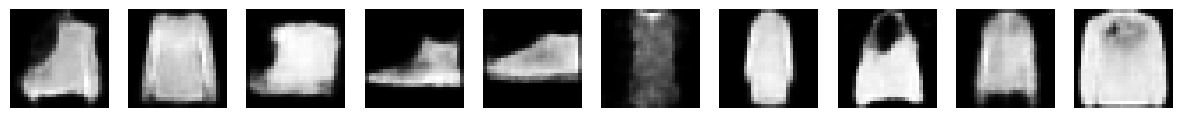

In [12]:
# Display generated images
n = 10
random_latent_points = np.random.normal(size=(n, latent_dim))
generated_images = decoder.predict(random_latent_points)

plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

# Interpolation within a class and between two different classes
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    interpolated_points = [(1 - ratio) * p1 + ratio * p2 for ratio in ratios]
    return np.array(interpolated_points)

def plot_interpolated_images(images):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()



1/1 [==============================] - 0s 28ms/step


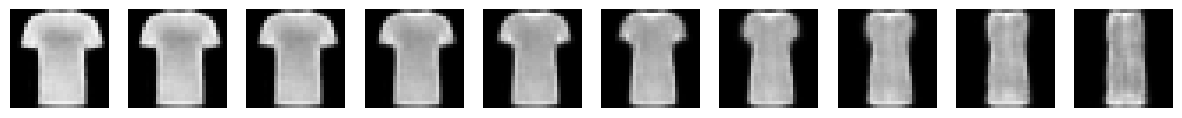

10/10 [==============================] - 0s 2ms/step


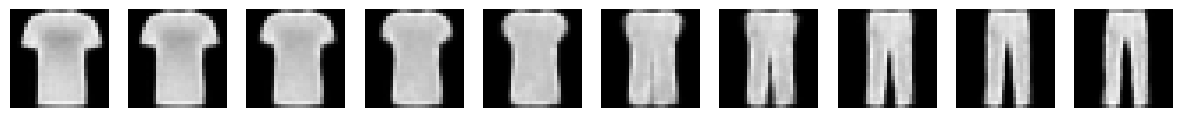

In [13]:
# Get random samples from a class
class_idx = 0
class_images = train_images[train_labels == class_idx][:2]

# Encode images to latent space
encoded = encoder.predict(class_images)[2]

# Interpolate between two points in the latent space
interpolated_latent_points = interpolate_points(encoded[0], encoded[1])

# Generate interpolated images
interpolated_images = decoder.predict(interpolated_latent_points)
plot_interpolated_images(interpolated_images)

# Get random samples from two different classes
class_idx1, class_idx2 = 0, 1
class_images1 = train_images[train_labels == class_idx1][0]
class_images2 = train_images[train_labels == class_idx2][0]

# Encode images to latent space
encoded1 = encoder.predict(class_images1.reshape(1, 28, 28, 1))[2]
encoded2 = encoder.predict(class_images2.reshape(1, 28, 28, 1))[2]

# Interpolate between two points in the latent space
interpolated_latent_points = interpolate_points(encoded1, encoded2)

# Generate interpolated images
interpolated_images = decoder.predict(interpolated_latent_points.reshape(-1, latent_dim), batch_size=1)
plot_interpolated_images(interpolated_images)

 What happens if you interpolate in between two points in the latent space for the respective encoded data points?
 When we interpolating between two points in the latent space of VAE andb then decode these interpolated points, we can observe a smooth transition between original images that corresponds to those points in latent space. The interpolation process essentially generates a sequence of images that transit from one image to other (as can be seen above). Also, good smoothness of this transition means that VAE has learned a continuous and meaningful representation of data in latent space. 

Use any other generative model and train it using the Fashion MNIST data. Describe how it is trained and the result.

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

buffer_size = train_images.shape[0]
batch_size = 256
epochs = 50
latent_dim = 100

# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

# Generator
def create_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

generator = create_generator()

# Discriminator
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = create_discriminator()

# Define the loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

train(train_dataset, epochs)


1/1 [==============================] - 0s 350ms/step


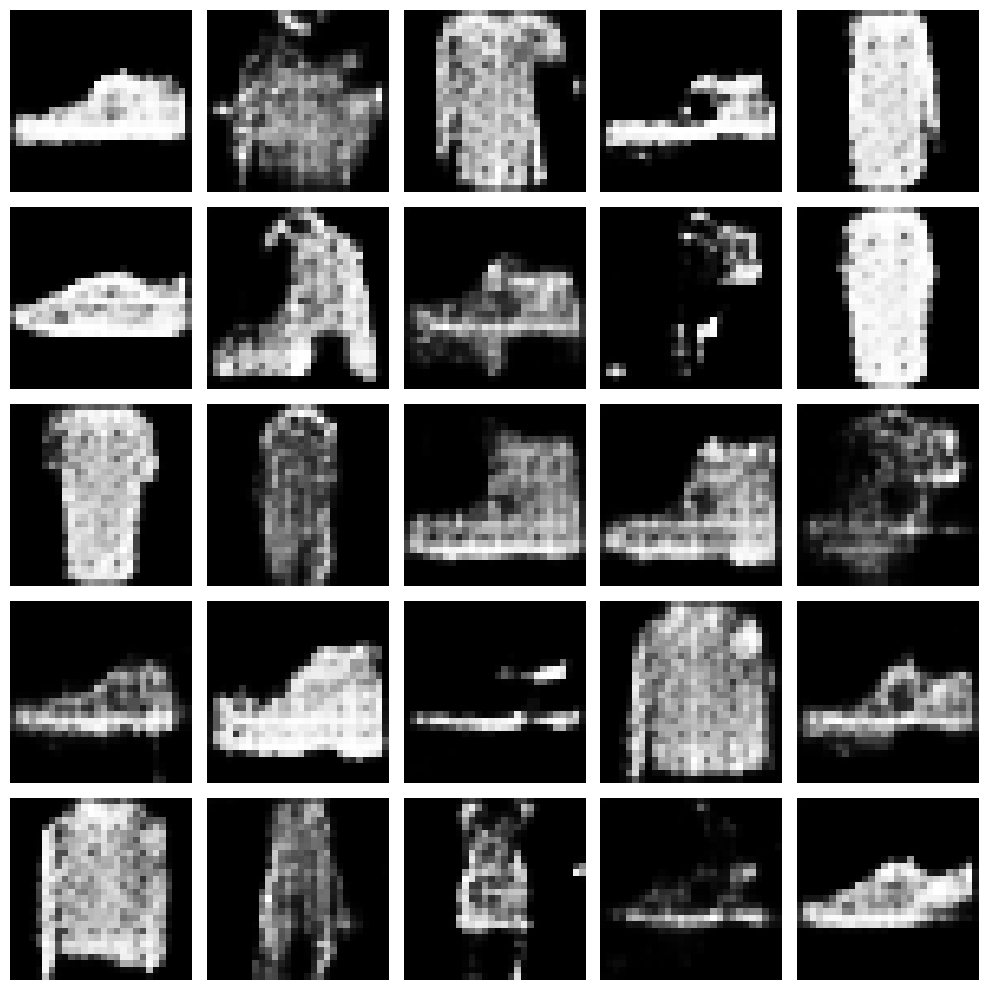

In [16]:
def plot_generated_images(generator, n_images=25, dim=(5, 5)):
    noise = np.random.normal(0, 1, size=(n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images to [0, 1]

    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_generated_images(generator)